In [0]:
# import pandas library
import pandas as pd

# import pyplot for plotting graph
import matplotlib.pyplot as plt

# import library numpy which helps to manipulate data
import numpy as np

# import package to split the given data into training and testing set
from sklearn.model_selection import train_test_split

In [0]:
# read the csv file by providing the location of file after mounting drive
dataset = pd.read_csv('/content/drive/My Drive/Dataset_Assignment/housing.csv')

# removed records with missing values
dataset = dataset.dropna()

In [0]:
# print first ten records of the dataset
print("First ten records of the dataset:")
dataset.head(10)

First ten records of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Plot for each feature of the dataset:


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe462787828>,
      dtype=object)

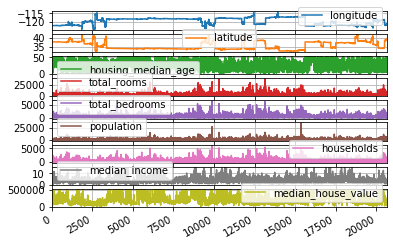

In [0]:
# plot each feature of the dataset on separate sub-plots
print("Plot for each feature of the dataset:")
dataset.plot(subplots = True, grid = True)

In [0]:
# we have to predict the value of median house value so selected that column in Y
Y = dataset['median_house_value']

# the othe remaining columns are selected in X
X = dataset.loc[:,'longitude':'median_income']

In [0]:
# split the dataset by maintaining the ratio of training to testing as 70:30 with random state as 2003
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2003)

# convert the values of training set to the numpy array
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

# convert the values of testing set to the numpy array
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch

# import 1D convolutional layer
from torch.nn import Conv1d

# import max pooling layer
from torch.nn import MaxPool1d

# import the flatten layer 
from torch.nn import Flatten

# import linear layer
from torch.nn import Linear

# import activation function (ReLU)
from torch.nn.functional import relu

# import libraries required for working with dataset from pytorch
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# defined model named as CnnRegressor and
# this model should be the subclass of torch.nn.Module 
class CnnRegressor(torch.nn.Module):
  # defined the initialization method
  def __init__(self, batch_size, inputs, outputs):
    # initialization of the superclass
    super(CnnRegressor, self).__init__()
    # store the parameters
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # define the input layer
    self.input_layer = Conv1d(inputs, batch_size, 1, stride = 1)
   
    # define max pooling layer
    self.max_pooling_layer = MaxPool1d(1)

    # define other convolutional layers
    self.conv_layer1 = Conv1d(batch_size, 128, 1, stride = 3)
    self.conv_layer2 = Conv1d(128, 256, 1, stride = 3)
    self.conv_layer3 = Conv1d(256, 512, 1, stride = 3)

    # define the flatten layer
    self.flatten_layer = Flatten()

    # define the linear layer
    self.linear_layer = Linear(512, 128)

    # define the output layer
    self.output_layer = Linear(128, outputs)

  # define the method to feed the inputs to the model
  def feed(self, input):
    # input is reshaped to the 1D array and fed into the input layer
    input = input.reshape((self.batch_size, self.inputs, 1))

    # ReLU is applied on the output of input layer
    output = relu(self.input_layer(input))

    # max pooling is applied and then Convolutions are done with ReLU
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer1(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer2(output))

    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer3(output))

    # flatten layer is applied
    output = self.flatten_layer(output)

    # linear layer and ReLu is applied
    output = relu(self.linear_layer(output))

    # finally, output layer is applied
    output = self.output_layer(output)
    return output

In [0]:
# import SGD for optimizer
from torch.optim import SGD

# import Adam for optimizer
from torch.optim import Adam

# to measure the performance import L1Loss
from torch.nn import L1Loss

# install pytorch's ignite and then import R2 score package
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [0]:
# define the batch size  
batch_size = 100
model = CnnRegressor(batch_size, X.shape[1], 1)

# we are using GPU so we have to set the model for that
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 100, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(100, 128, kernel_size=(1,), stride=(3,))
  (conv_layer2): Conv1d(128, 256, kernel_size=(1,), stride=(3,))
  (conv_layer3): Conv1d(256, 512, kernel_size=(1,), stride=(3,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=512, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
# define the method for calculating average L1 Loss and R2 Score of given model
def model_loss(model, dataset, train = False, optimizer = None):
  # first calculated for the batches and at the end get the average
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    # get predictions of the model for training set
    predictions = model.feed(input)

    # calculate loss of the model
    loss = performance(predictions, output)

    # compute the R2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      # clear the errors
      optimizer.zero_grad()

      # compute the gradients for optimizer
      loss.backward()

      # use optimizer in order to update parameters
      # of the model based on gradients
      optimizer.step()

    # store the loss and update values
    avg_loss += loss.item()
    avg_score += score
    count += 1

  return avg_loss/count, avg_score/count

In [0]:
# define the number of epochs
epochs = 100

# define the performance measure and optimizer
# optimizer = SGD( model.parameters(), lr= 1e-5)
optimizer = Adam(model.parameters(), lr = 0.007)

# to process with GPU, training set is converted into torch variable
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

# loop for number of epochs and calculate average loss
for epoch in range(epochs):
   # model is cycled through the batches
  avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer = optimizer)
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

torch.save(model.state_dict(),'/content/drive/My Drive/Dataset_Assignment/1095526_1dconv_reg.h')

Epoch 1:
	Loss = 96361.97388548951
	R^2 Score = -1.1490257390102019
Epoch 2:
	Loss = 76784.07831621503
	R^2 Score = 0.257237431910874
Epoch 3:
	Loss = 71107.91638439686
	R^2 Score = 0.32980035505315114
Epoch 4:
	Loss = 68604.83965253497
	R^2 Score = 0.35360721754449487
Epoch 5:
	Loss = 66135.33962521853
	R^2 Score = 0.3698669909502445
Epoch 6:
	Loss = 63664.13404173951
	R^2 Score = 0.4516674437760197
Epoch 7:
	Loss = 63747.88718312937
	R^2 Score = 0.39992065683358663
Epoch 8:
	Loss = 60879.921055506995
	R^2 Score = 0.5010110451587602
Epoch 9:
	Loss = 61075.903928103144
	R^2 Score = 0.5188954217541446
Epoch 10:
	Loss = 57606.03092220279
	R^2 Score = 0.5184301204423966
Epoch 11:
	Loss = 60387.92722902098
	R^2 Score = 0.4938210310581683
Epoch 12:
	Loss = 57538.48483937937
	R^2 Score = 0.5451951730647122
Epoch 13:
	Loss = 56777.080255681816
	R^2 Score = 0.5524010025861603
Epoch 14:
	Loss = 55731.57632211538
	R^2 Score = 0.5431175747189003
Epoch 15:
	Loss = 54385.56411166958
	R^2 Score = 0.

In [0]:
# to process with GPU, testing set is converted into torch variable
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

# create the DataLoader instance to work with batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last = True)

# output of the performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 49032.256531762294
The model's R^2 score is: 0.6658213210099228
